In [50]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

# 단지내주차면수로 data split
모든 단지내주차면수의 값을 기준으로 data를 split하는 방법을 반복 <br>
이 때 두 그룹의 분산의 합이 작아지는 값을 선택 

In [27]:
danjis = train[["단지코드","단지내주차면수","등록차량수"]].drop_duplicates().reset_index(drop=True).sort_values(by="단지내주차면수").reset_index(drop=True)

In [28]:
ee = []
for idx,i in enumerate (danjis.단지내주차면수):
    ee.append(np.var(danjis.loc[:idx,"등록차량수"])*idx+ 
              np.var(danjis.loc[idx:,"등록차량수"])*(len(danjis)-idx))

In [40]:
print(f"mininum np.argmin(ee): {np.argmin(ee)}")
print(f"ee가 {np.argmin(ee)}일 때의 단지내주차면수: {danjis.단지내주차면수[np.argmin(ee)]}")

mininum np.argmin(ee): 250
ee가 250일 때의 단지내주차면수: 629.0


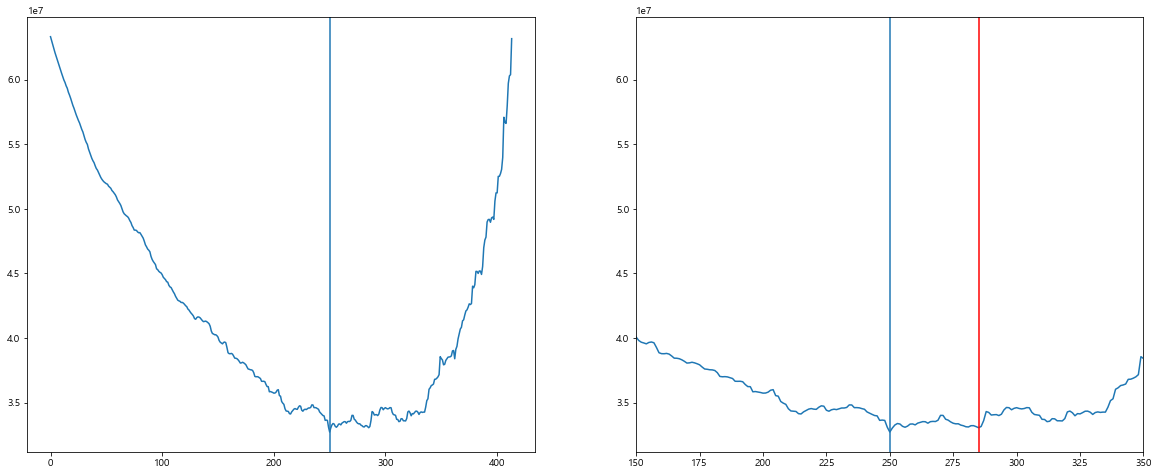

In [45]:
fig, ax = plt.subplots(figsize=(20,8),ncols=2)
ax[0].plot(ee)
ax[0].axvline(x=np.argmin(ee))
ax[1].plot(ee)
ax[1].axvline(x=np.argmin(ee))
ax[1].axvline(x=285, color="red")
plt.xlim([150,350])
plt.show()

In [51]:
# ee[250:300]
print(ee[250])
print(ee[285])

32720367.313552804
33053884.377083033


분산의 최솟값(250) 대신 비교적 안정적으로 보이는 지점(285) 선택

In [52]:
danjis1 = danji[:285]
danjis2 = danji[285:]
print(len(danjis1), len(danjis2))

285 129


In [53]:
danjis[danjis.단지내주차면수 <722].shape, danjis[danjis.단지내주차면수 >=722].shape

((285, 3), (129, 3))

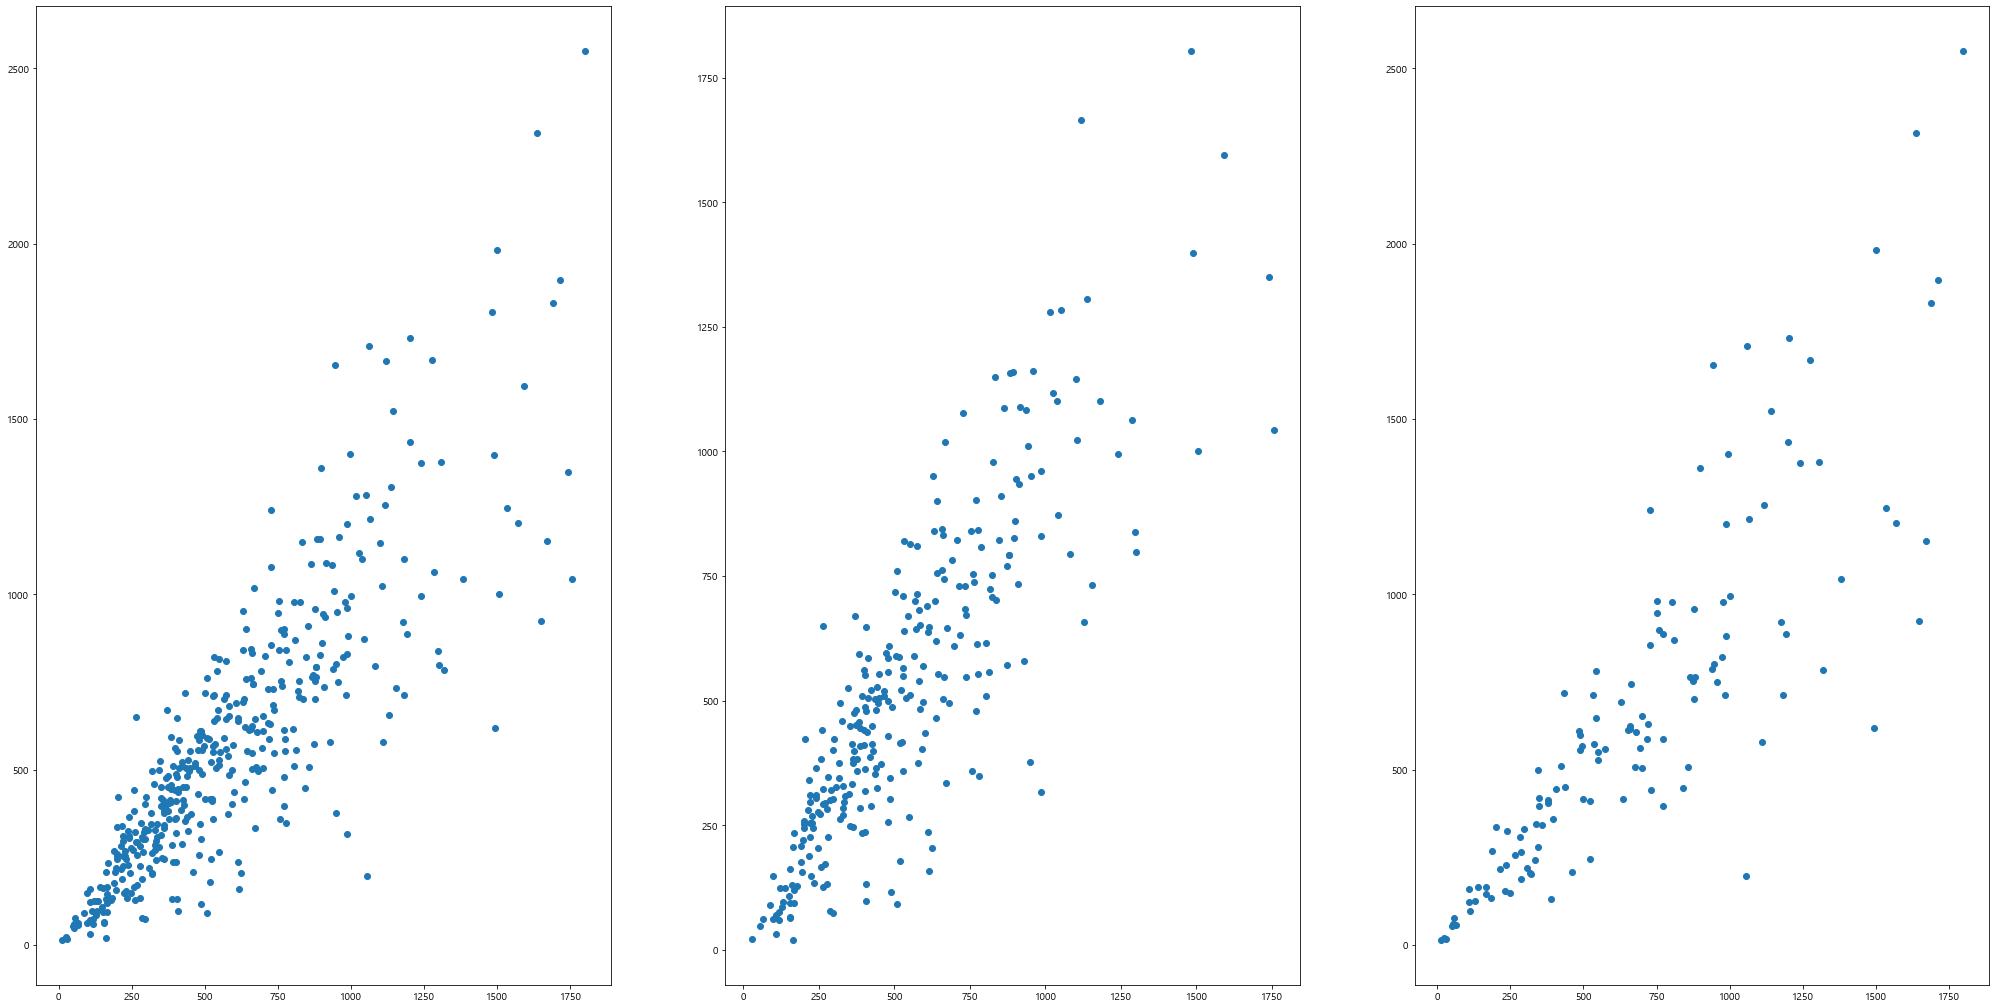

In [34]:
fig= plt.figure(figsize=(35,18))
plt.subplot(1,3,1)
plt.scatter(danjis.단지내주차면수,danjis.등록차량수)
plt.subplot(1,3,2)
plt.scatter(danjis1.단지내주차면수,danjis1.등록차량수)
plt.subplot(1,3,3)
plt.scatter(danjis2.단지내주차면수,danjis2.등록차량수)
plt.show()

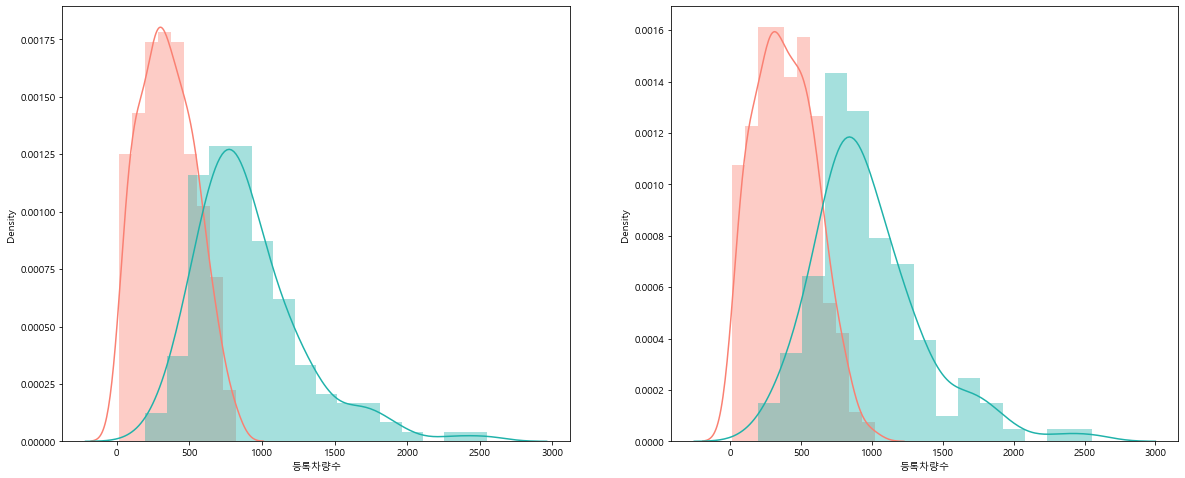

In [58]:
fig, ax = plt.subplots(figsize=(20,8),ncols=2)
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(danjis.등록차량수[danjis.단지내주차면수<danjis.단지내주차면수[np.argmin(ee)]], color="salmon", ax=ax[0])
sns.distplot(danjis.등록차량수[danjis.단지내주차면수>=danjis.단지내주차면수[np.argmin(ee)]], color="lightseagreen", ax=ax[0])
sns.distplot(danjis.등록차량수[danjis.단지내주차면수<danjis.단지내주차면수[285]], color="salmon", ax=ax[1])
sns.distplot(danjis.등록차량수[danjis.단지내주차면수>=danjis.단지내주차면수[285]], color="lightseagreen", ax=ax[1])
plt.show()

In [55]:
print(f"단지내주차면수 기준 split 지점: {danjis.단지내주차면수[285]}")

단지내주차면수 기준 split 지점: 722.0


# Quantile로 나눠서 확인


In [3]:
q2 = list(train["단지내주차면수"].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))
q2

[13.0, 166.0, 240.0, 334.0, 407.0, 507.0, 638.0, 756.0, 895.0, 1148.0, 1798.0]

In [4]:
train["y_class2"] = [99]*len(train)
for i in range(len(q2[:-1])):
    train.loc[(train["단지내주차면수"]>=q2[i])&(train["단지내주차면수"]<q2[i+1]),"y_class2"] = i
train.loc[train["단지내주차면수"]==q2[10],"y_class2"] = 9

In [5]:
train[["등록차량수","y_class2"]]

,등록차량수,y_class2
0,205.0000,5
1,205.0000,5
2,205.0000,5
3,205.0000,5
4,205.0000,5
...,...,...
2891,62.0000,0
2892,62.0000,0
2893,62.0000,0
2894,62.0000,0


In [9]:
y = train["y_class2"]
train2 = train.drop(["단지코드",'위도', '경도','등록차량수','지역','자격유형', '공급유형','y_class2'],axis=1)
test2 = test[train2.columns]

In [ ]:
col = ['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '지하철역',
       '버스정류장', '단지내주차면수', '등록차량수', '연면적', '위도', '경도', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율']

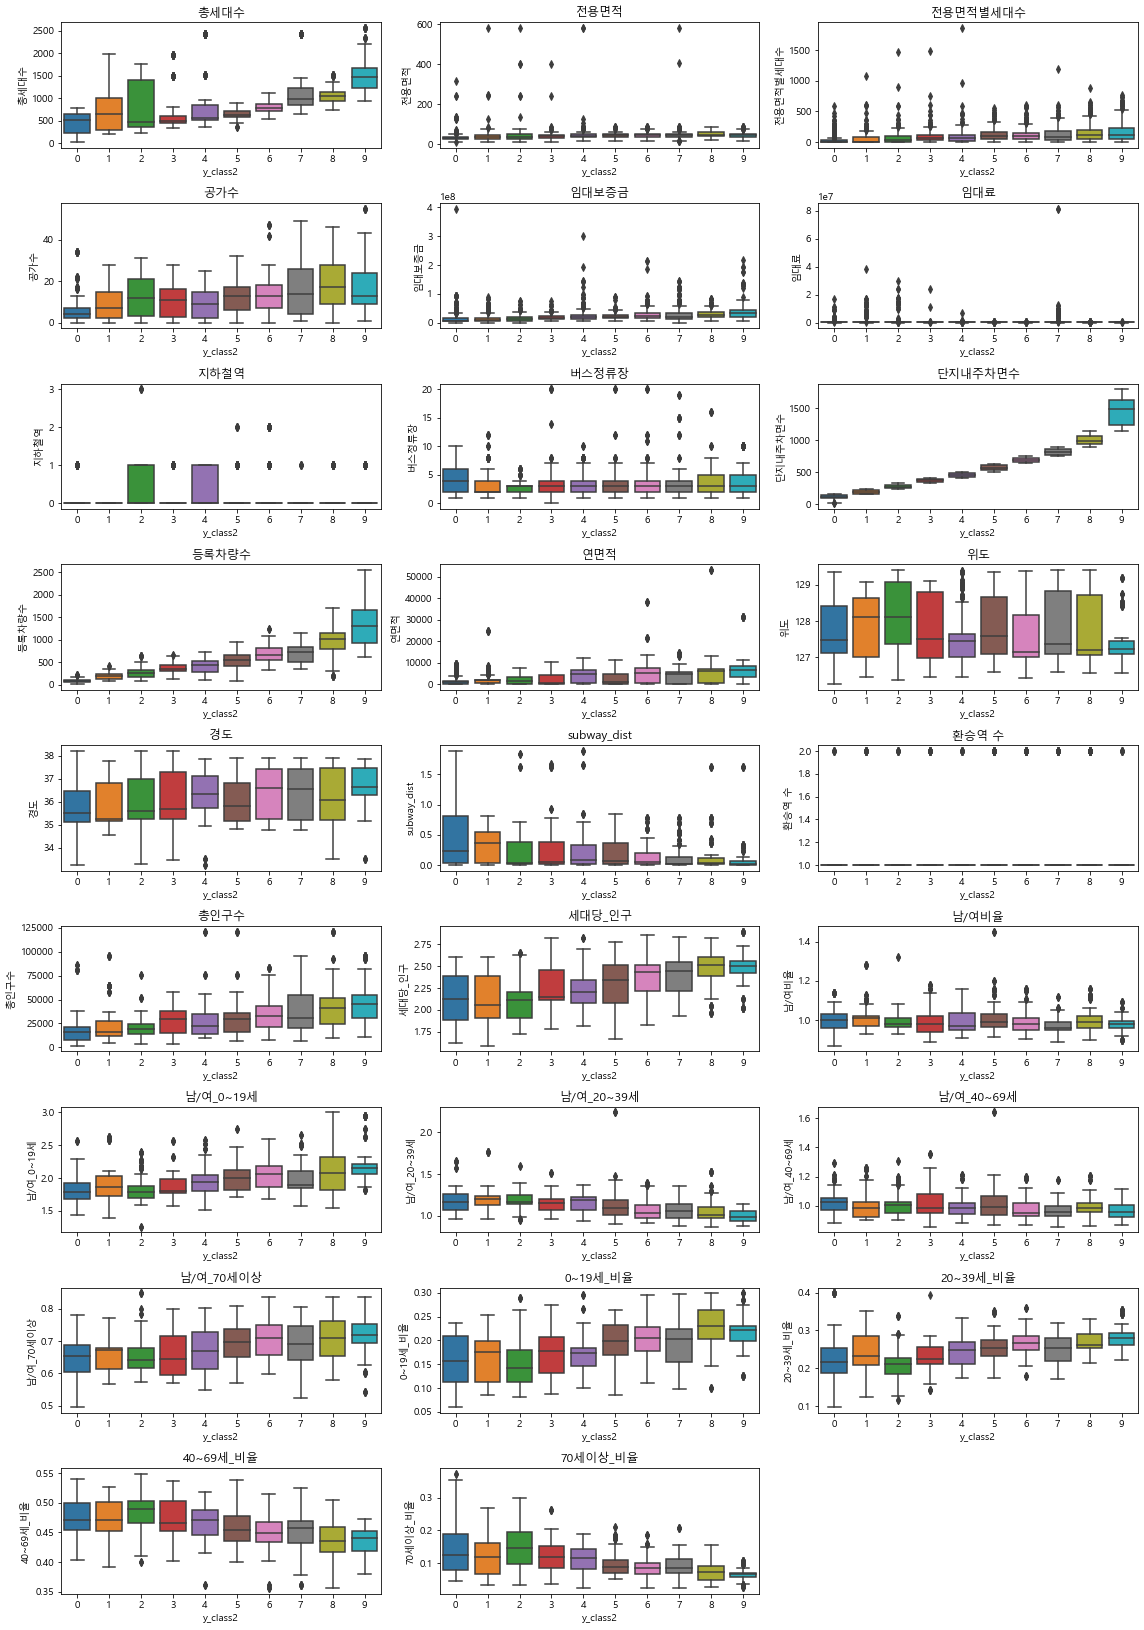

In [11]:
plt.figure(figsize=(16,60))
for i,r in enumerate(col):
    plt.subplot(24,3,i+1)
    sns.boxplot(train.y_class2, train[r])
    plt.title(r)
plt.tight_layout()
plt.show()

# LDA, QDA로 cv
5-fold로 나눠서 confusion matrix로 예측 결과 파악

In [24]:
train2 = train.drop(["단지코드",'임대건물구분','단지명','subway_name','도로명주소','위도', '경도','등록차량수','지역','자격유형', '공급유형','y_class2'],axis=1)
test2 = test[train2.columns]

scaler = StandardScaler().fit(train2)

X_tr = scaler.transform(train2)
X_tst = scaler.transform(test2)

In [47]:
def St_fit(model):
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(X_tr, y)
    ac_tr = []
    ac_tst = []
    StratifiedKFold(n_splits = 5, 
                    random_state = 42, shuffle=True)
    i = 0
    for train_index, test_index in skf.split(X_tr, y):
        i += 1
        print(f"{i}th fold")
        X_train, X_test = X_tr[train_index], X_tr[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model
        clf.fit(X_train, y_train)
        print("<confusion_matrix for train>")
        print(confusion_matrix(y_train,clf.predict(X_train)))
        print("<confusion_matrix for test>")
        print(confusion_matrix(y_test,clf.predict(X_test)))
        ac_tr.append(accuracy_score(y_train,clf.predict(X_train)))
        ac_tst.append(accuracy_score(y_test,clf.predict(X_test)))
        print("--"*40)
    print("--"*40)
    print(f"ac_tr: {ac_tr}")
    print(f"ac_tst: {ac_tst}")

In [48]:
model = LinearDiscriminantAnalysis()
St_fit(model)

1th fold
<confusion_matrix for train>
[[185  28  16   0   0   0   0   0   0   0]
 [  8 175  32   0   0   0   0   0   0   0]
 [  3  25 173  49   1   0   0   0   0   0]
 [  0   9  37 145  32   0   0   0   0   0]
 [  0   0   0  28 190  22   0   0   0   0]
 [  0   0   0   4   7 203  12   0   0   0]
 [  0   0   0   0   0  16 167  24   0   0]
 [  0   0   0   0   0   0  23 229   5   0]
 [  0   0   0   0   0   0   0  26 210   0]
 [  0   0   0   0   0   0   0   0  40 192]]
<confusion_matrix for test>
[[30 14 13  0  0  0  0  0  0  0]
 [14 25  8  7  0  0  0  0  0  0]
 [ 0  8 26 26  2  0  0  0  0  0]
 [ 0  0  7 41  8  0  0  0  0  0]
 [ 0  0  0 12 37 12  0  0  0  0]
 [ 0  0  0  0  8 34 15  0  0  0]
 [ 0  0  0  0  0  9 43  0  0  0]
 [ 0  0  0  0  0  0 22 34  9  0]
 [ 0  0  0  0  0  0  0  4 54  0]
 [ 0  0  0  0  0  0  0  0  4 54]]
--------------------------------------------------------------------------------
2th fold
<confusion_matrix for train>
[[176  34  19   0   0   0   0   0   0   0]
 [ 20 185 

In [49]:
model = QuadraticDiscriminantAnalysis()
St_fit(model)

1th fold
<confusion_matrix for train>
[[221   8   0   0   0   0   0   0   0   0]
 [  0 215   0   0   0   0   0   0   0   0]
 [  0   2 242   7   0   0   0   0   0   0]
 [  0   0   6 207  10   0   0   0   0   0]
 [  0   0   0   0 228  12   0   0   0   0]
 [  0   0   0   0   0 226   0   0   0   0]
 [  0   0   0   0   0   1 206   0   0   0]
 [  0   0   0   0   0   0   6 230  21   0]
 [  0   0   0   0   0   0   0   0 236   0]
 [  0   0   0   0   0   0   0   0   1 231]]
<confusion_matrix for test>
[[16 15 18  3  3  1  0  0  0  1]
 [ 0 37 11  5  0  0  0  0  0  1]
 [ 0  2 37 23  0  0  0  0  0  0]
 [ 0  0 15 22 19  0  0  0  0  0]
 [ 0  0  0  0 39 21  0  1  0  0]
 [ 0  0  0  0  2 31 24  0  0  0]
 [ 0  0  0  0  0 19 23  2  8  0]
 [ 0  0  0  0  0  0  7 13 41  4]
 [ 0  0  0  0  0  0 18  3 32  5]
 [ 0  0  0  0  0  0  0  0 39 19]]
--------------------------------------------------------------------------------
2th fold
<confusion_matrix for train>
[[214  15   0   0   0   0   0   0   0   0]
 [  1 155 

# K-means 클러스터링으로 
5-fold로 나눠서 confusion matrix로 예측 결과 파악

In [58]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_tr)
print(kmeans.predict(X_tst))
print(pd.DataFrame(kmeans.labels_).value_counts()/len(kmeans.labels_))

[1 1 1 ... 0 0 0]
0   0.5307
1   0.4693
dtype: float64


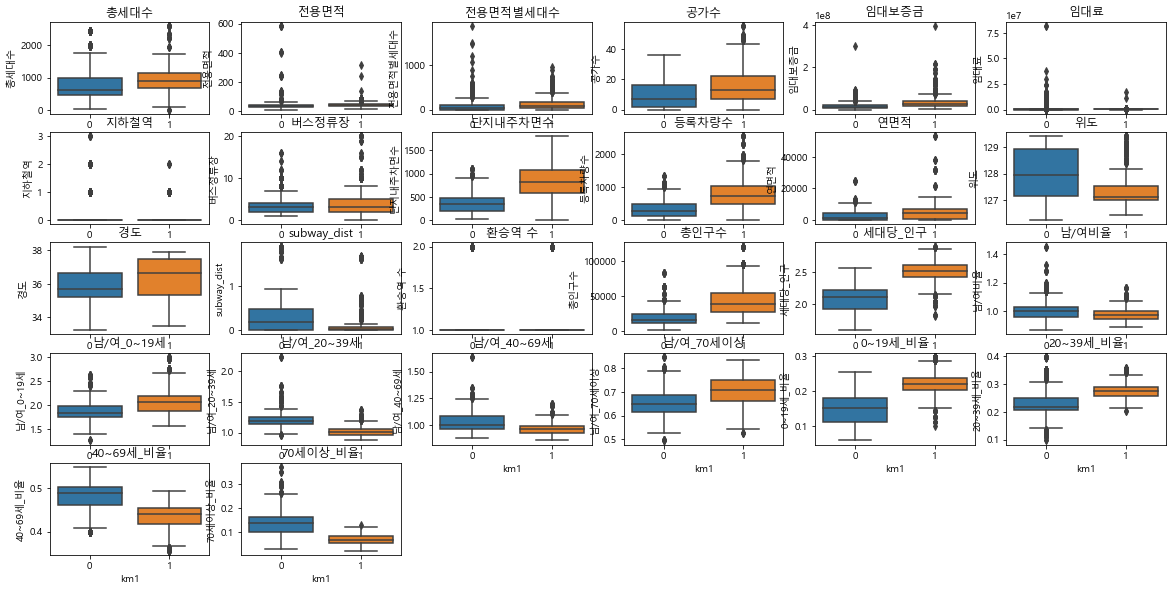

In [57]:
train["km1"] = kmeans.labels_
plt.figure(figsize=(20,24))
for i,r in enumerate(col):
    plt.subplot(12,6,i+1)
    sns.boxplot(train.km1, train[r])
    plt.title(r)

In [59]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_tr)
print(kmeans.predict(X_tst))
print(pd.DataFrame(kmeans.labels_).value_counts()/len(kmeans.labels_))

[0 0 0 ... 2 2 2]
0   0.4009
2   0.3785
1   0.2206
dtype: float64


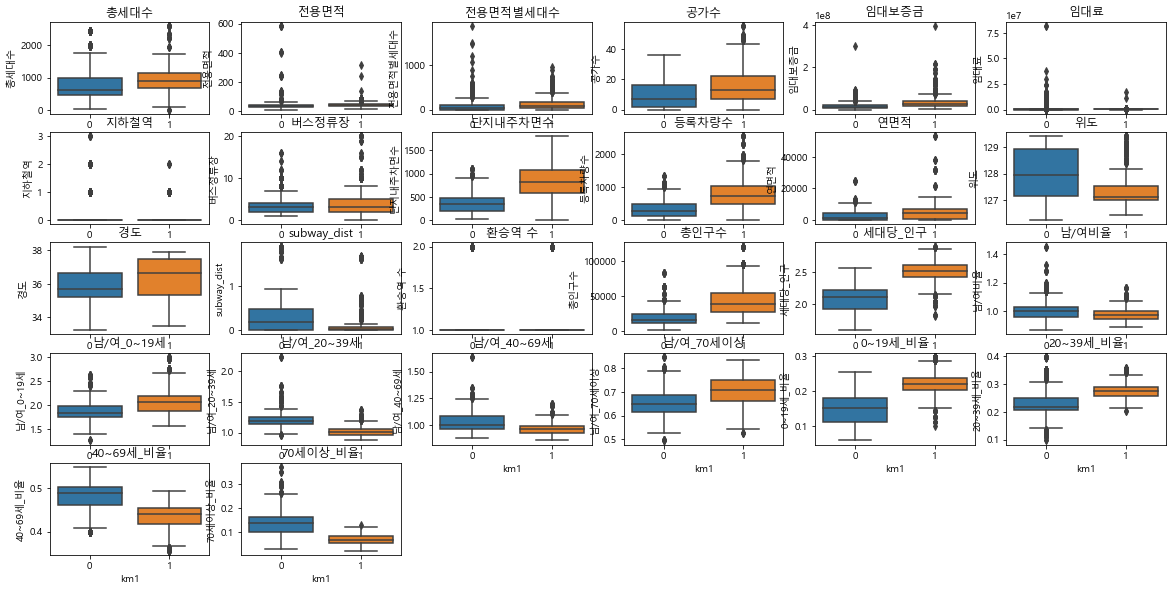

In [60]:
train["km2"] = kmeans.labels_
plt.figure(figsize=(20,24))
for i,r in enumerate(col):
    plt.subplot(12,6,i+1)
    sns.boxplot(train.km1, train[r])
    plt.title(r)

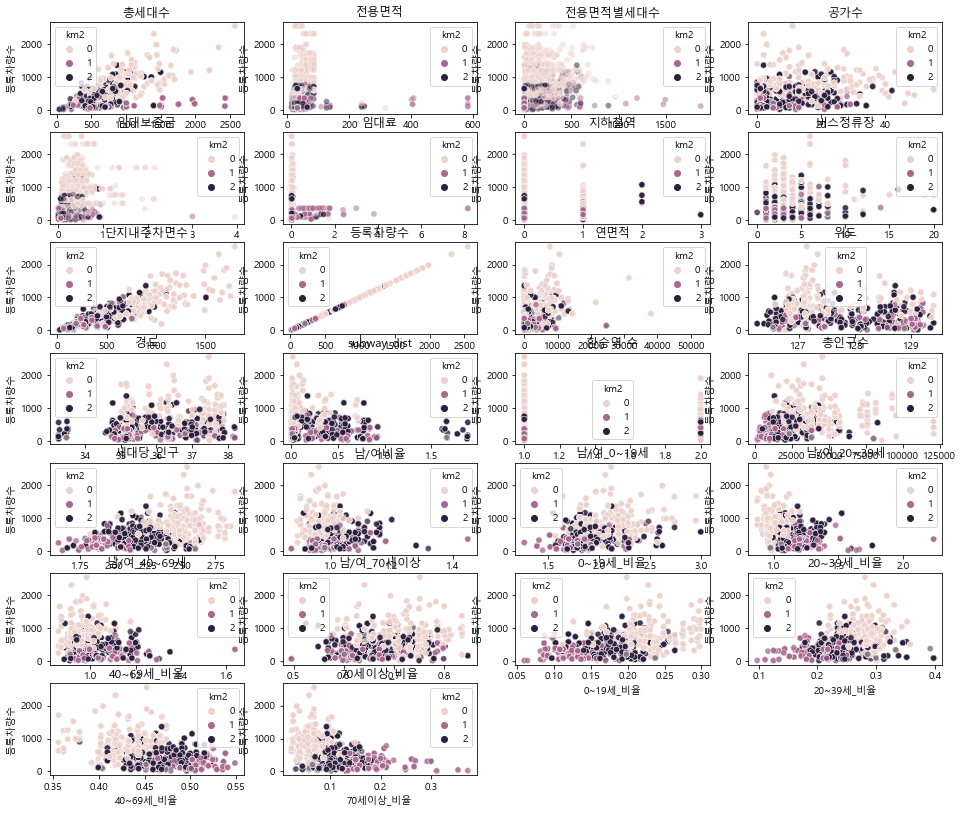

In [62]:
plt.figure(figsize=(16,24))
for i,r in enumerate(col):
    plt.subplot(12,4,i+1)
    sns.scatterplot(x = r,y = "등록차량수", hue = "km2",data = train,alpha = 0.5)
    plt.title(r)